In [1]:
# Define a global file path variable
file_path = "C://Users//User//Raiza//Econ 138//Problem Set 2"

In [2]:
!pip install shapely
!pip install folium
!pip install rasterio
!pip install googlemaps
!pip install osmnx
!pip install networkx

In [18]:
# Standard library imports
import os

# Third-party imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import folium
import rasterio
import googlemaps
import osmnx as ox
import networkx as nx

# Local application/library specific imports
from rasterio.plot import show
from geopandas import GeoDataFrame
from geopandas import points_from_xy
from shapely.geometry import Point
from shapely.ops import unary_union
from shapely.ops import transform
from shapely import wkt
from matplotlib.lines import Line2D

In [4]:
# South Africa: Replicating Map of Dam Locations with Population Density Overlay
# Objective: Replace river gradient in the original figure with 2020 population density
# Dataset: "zaf_pd_2020_1km.tif" from WorldPop - https://data.humdata.org/

# Define the data path variable for South Africa
SA_data_path = "C://Users//User//Raiza//Econ 138//Problem Set 2//1 South Africa"

In [5]:
# Load the shapefile for district boundaries in South Africa
SA_districts = gpd.read_file(os.path.join(SA_data_path, "MDB_Local_Municipal_Boundary_2018.shp"))
SA_districts.info()

# Check coordinate reference system and column names
print(SA_districts.crs)
print(SA_districts.columns)                             

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   FID         213 non-null    int32         
 1   OBJECTID    213 non-null    int32         
 2   PROVINCE    213 non-null    object        
 3   CATEGORY    213 non-null    object        
 4   CAT2        213 non-null    object        
 5   CAT_B       213 non-null    object        
 6   MUNICNAME   213 non-null    object        
 7   NAMECODE    213 non-null    object        
 8   MAP_TITLE   213 non-null    object        
 9   DISTRICT    213 non-null    object        
 10  DISTRICT_N  213 non-null    object        
 11  DATE        213 non-null    datetime64[ms]
 12  Shape__Are  213 non-null    float64       
 13  Shape__Len  213 non-null    float64       
 14  geometry    213 non-null    geometry      
dtypes: datetime64[ms](1), float64(2), geometry(1), int32(2), object(9)

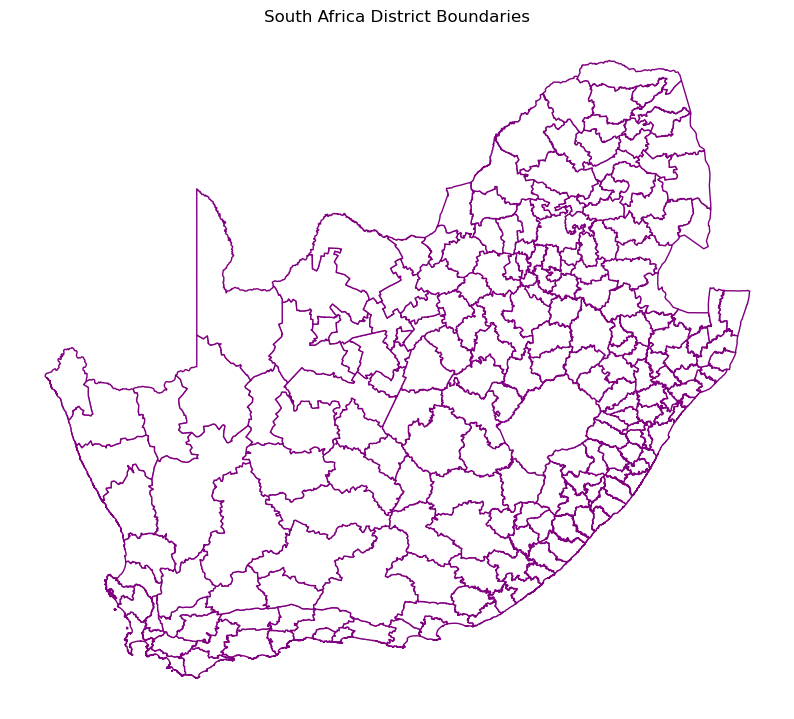

In [6]:
# Plot district boundaries
fig, ax = plt.subplots(figsize=(10, 10))
SA_districts.plot(ax=ax, color='white', edgecolor='purple')
plt.title("South Africa District Boundaries")
plt.axis("off")
plt.show()

In [7]:
# Load dam location data
SA_dams = pd.read_excel(os.path.join(SA_data_path, "Dams_south_africa.xlsx"))

In [8]:
# Convert coordinates to decimal degrees
# Note: Latitude values are negative (Southern Hemisphere)
SA_dams["Latitude"] = -SA_dams["Latitude deg"] - SA_dams["Lat min"]/60 - SA_dams["Lat sec"]/3600
SA_dams["Longitude"] = SA_dams["Longitude deg"] + SA_dams["Long min"]/60 + SA_dams["Long sec"]/3600

print(SA_dams[["Name of dam", "Latitude", "Longitude"]].head())

         Name of dam   Latitude  Longitude
0       NGOTWANE DAM -25.198333  25.813333
1      MAKGOPANE DAM -25.098389  25.882500
2    ROODEKOPJES DAM -25.406667  27.577500
3  HARTBEESPOORT DAM -25.725639  27.848361
4   BUFFELSPOORT DAM -25.780417  27.487361


In [9]:
# Convert DataFrame to GeoDataFrame with geometry column
SA_dams["geometry"] = points_from_xy(SA_dams["Longitude"], SA_dams["Latitude"])
SA_dams_gdf = gpd.GeoDataFrame(SA_dams, geometry="geometry")
SA_dams_gdf.set_crs(epsg=4326, inplace=True)

,Name of dam,Latitude deg,Lat min,Lat sec,Longitude deg,Long min,Long sec,Latitude,Longitude,geometry
0,NGOTWANE DAM,25.0,11.0,54.0,25.0,48.0,48.0,-25.198333,25.813333,POINT (25.81333 -25.19833)
1,MAKGOPANE DAM,25.0,5.0,54.2,25.0,52.0,57.0,-25.098389,25.882500,POINT (25.8825 -25.09839)
2,ROODEKOPJES DAM,25.0,24.0,24.0,27.0,34.0,39.0,-25.406667,27.577500,POINT (27.5775 -25.40667)
3,HARTBEESPOORT DAM,25.0,43.0,32.3,27.0,50.0,54.1,-25.725639,27.848361,POINT (27.84836 -25.72564)
4,BUFFELSPOORT DAM,25.0,46.0,49.5,27.0,29.0,14.5,-25.780417,27.487361,POINT (27.48736 -25.78042)
...,...,...,...,...,...,...,...,...,...,...
10307,TSHAKHUMA DAM,23.0,1.0,58.0,30.0,16.0,55.0,-23.032778,30.281944,POINT (30.28194 -23.03278)
10308,KORENTEPOORT DAM,34.0,0.0,17.4,21.0,9.0,56.4,-34.004833,21.165667,POINT (21.16567 -34.00483)
10309,GRASSRIDGE DAM,31.0,46.0,4.2,25.0,27.0,57.9,-31.767833,25.466083,POINT (25.46608 -31.76783)
10310,KNELLPOORT DAM,29.0,46.0,54.4,26.0,53.0,19.2,-29.781778,26.888667,POINT (26.88867 -29.78178)


In [10]:
# Check CRS compatibility with districts shapefile
print("District CRS:", SA_districts.crs)
print("Dam CRS:", SA_dams_gdf.crs)

District CRS: EPSG:4326
Dam CRS: EPSG:4326


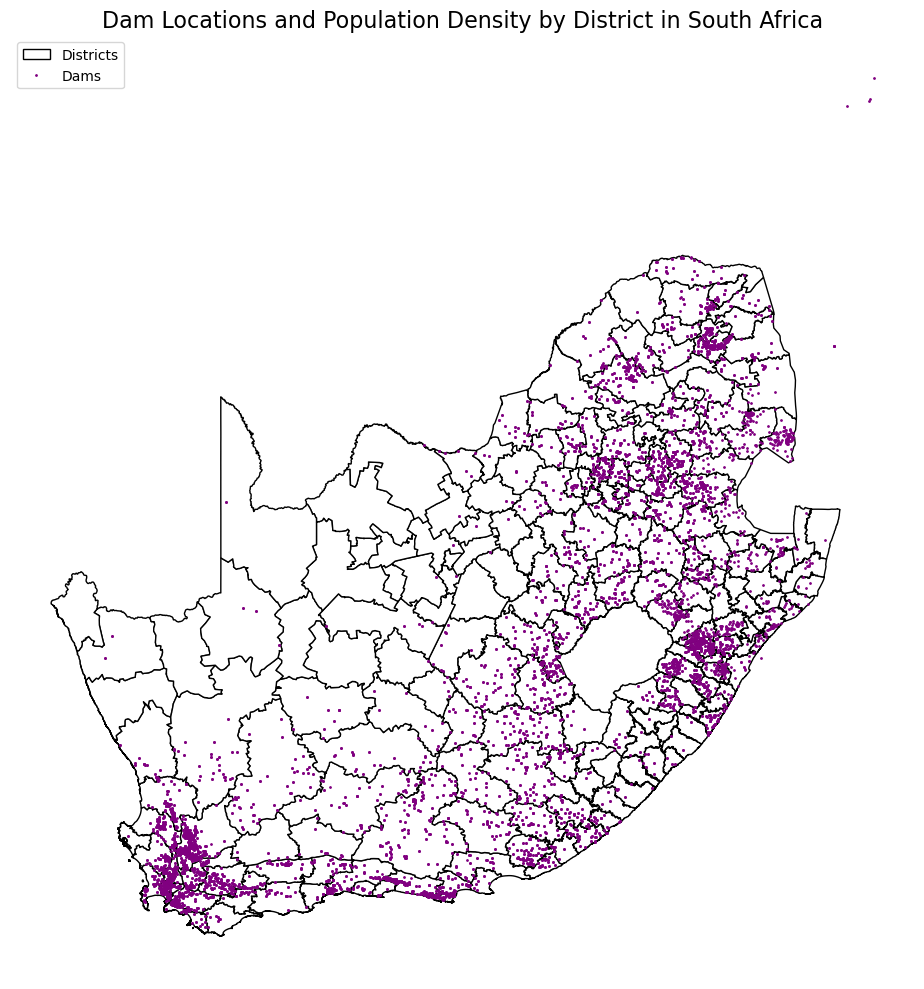

In [11]:
# Plot districts and dam locations on the same map
fig, ax = plt.subplots(figsize=(10, 10))
SA_districts.plot(ax=ax, color='white', edgecolor='black')
SA_dams_gdf.plot(ax=ax, color='purple', markersize=1)

# Create custom legend entries
districts_patch = mpatches.Patch(facecolor='white', edgecolor='black', label='Districts')
dams_marker = Line2D([0], [0], marker='o', color='purple', markersize=1, label='Dams', linestyle='None')

# Additional plot settings
ax.legend(handles=[districts_patch, dams_marker], loc="best")
plt.title("Dam Locations and Population Density by District in South Africa", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()

In [12]:
# Load 2020 population density raster file
SA_popden = rasterio.open(os.path.join(SA_data_path, "zaf_pd_2020_1km.tif"))

# Match the CRS of population raster and district boundaries
SA_districts = SA_districts.to_crs(SA_popden.crs)

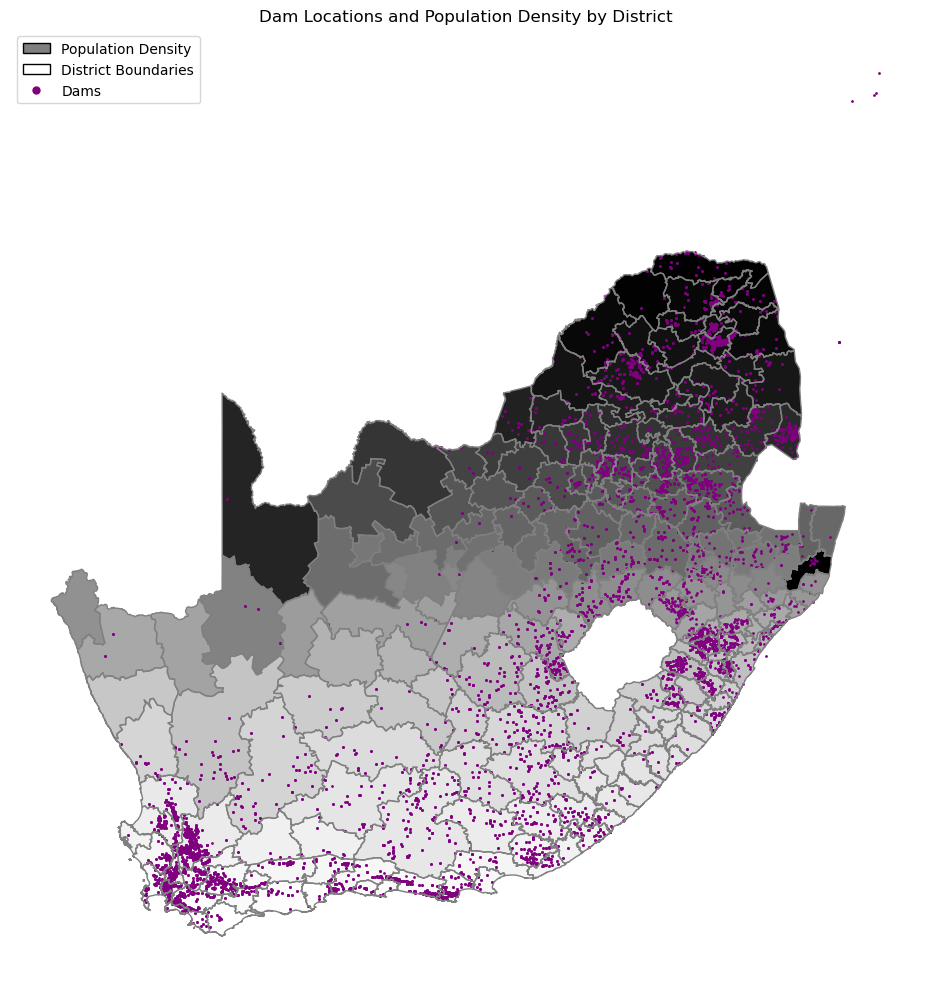

In [13]:
# Plot district boundaries with dams and add a population density background
fig, ax = plt.subplots(figsize=(10, 10))
SA_districts.boundary.plot(ax=ax, edgecolor="gray", linewidth=1)
SA_districts.plot(ax=ax, legend=True, cmap="Greys", 
                      legend_kwds={"label": "Population Density (people/km²)", "orientation": "horizontal"})
SA_dams_gdf.plot(ax=ax, color='purple', markersize=1)

# Define Legend Elements
districts_patch = mpatches.Patch(facecolor="gray", edgecolor="black", label="Population Density")
boundary_patch = mpatches.Patch(facecolor="white", edgecolor="black", label="District Boundaries")
dams_marker = Line2D([0], [0], marker="o", color="purple", markersize=5, label="Dams", linestyle="None")

# Additional plot settings
ax.legend(handles=[districts_patch, boundary_patch, dams_marker], loc="best")
plt.title("Dam Locations and Population Density by District")
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
# Ethiopia: Replicating Figure 4: Ethiopian Population density and ERSS Sample Villages
# Objective: Visualize Ethiopia's population density alongside roads, electric networks, generators, and ERSS sample villages.
# Dataset: 2020 Population data from WorldPop - https://data.humdata.org/

# Define the data path variable for Ethiopia
ET_data_path = "C://Users//User//Raiza//Econ 138//Problem Set 2//2 Ethiopia"

In [15]:
# Load administrative boundaries
ET_districts_gdf = gpd.read_file(os.path.join(ET_data_path, "Ethiopia_AdminBoundaries.shp"))
print(ET_districts_gdf.crs)
ET_districts_gdf

EPSG:4326


,OBJECTID,REGIONNAME,ZONENAME,WOREDANO_,WOREDANAME,GlobalID,Shape__Are,Shape__Len,geometry
0,1,Addis Ababa,Region 14,140102,Nefas Silk,695a39eb-38a2-4680-82e3-c34d7559ee45,6.019472e+07,42074.127942,"MULTIPOLYGON (((38.70186 8.92537, 38.70185 8.9..."
1,2,Addis Ababa,Region 14,140104,Bole,d21bf315-15e2-40eb-9a55-92e102600a0f,1.317679e+08,57202.004332,"POLYGON ((38.89908 8.95556, 38.89754 8.95547, ..."
2,3,Addis Ababa,Region 14,140105,Lideta,7f82355a-ed21-48bd-9d49-2e3cb58b824b,1.134951e+07,20053.075002,"POLYGON ((38.75398 9.01721, 38.75398 9.01718, ..."
3,4,Addis Ababa,Region 14,140106,Kirkos,deb15e6d-331b-433e-bdb8-cd5dfca4bb79,1.512233e+07,19354.492903,"POLYGON ((38.76493 9.02229, 38.76499 9.02216, ..."
4,5,Addis Ababa,Region 14,140107,Yeka,1f7e0179-f18e-43c1-9838-9ad28d2a6e1a,8.901921e+07,47690.016803,"POLYGON ((38.89684 9.02942, 38.89097 9.02327, ..."
...,...,...,...,...,...,...,...,...,...
679,680,SNNPR,Gurage,070109,Gumer,823c7b7c-ab26-4255-b459-d4ea57fdffc8,2.042026e+08,67203.178529,"POLYGON ((38.0664 7.89435, 38.06031 7.88358, 3..."
680,681,SNNPR,Segen Peoples',None,Alle,f689ede0-c182-4331-aa83-cdb26c99382e,1.065196e+09,183068.475861,"POLYGON ((37.12637 5.72452, 37.12725 5.72444, ..."
681,682,SNNPR,Segen Peoples',071601,Derashe,9e03bdc6-a6b3-41f4-a48e-7b95682fb9b3,7.265555e+08,179539.187123,"POLYGON ((37.56279 5.71065, 37.56576 5.69569, ..."
682,683,SNNPR,Gamo Gofa,071012,Kemba,d269c6a4-ba68-4f20-b6cd-4f9a70f03bc9,1.264534e+09,186707.754503,"POLYGON ((37.2945 5.98755, 37.28325 5.98294, 3..."


In [16]:
# Load road infrastructure
ET_roads = gpd.read_file(os.path.join(ET_data_path, "Ethiopia_Roads.shp"))
print(ET_roads.crs)
ET_roads

C:\Users\User\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


EPSG:4326


,LINKNO,ROADNO,STARTKM,ENDKM,LENGTHKM,STARTDESC,ENDDESC,CLASSLOC,CLASS,REGION,WIDTH,LANES,PAVEMTYPE,SURFTYPE,CONDITION,AADT,geometry
0,A3-8,A3,0.0,54.0,54.00,Bahirdar,Woreta,Trunk,Primary,Amhara,7.0,2.0,Asphalt,Paved,Very Good,481.0,"LINESTRING (37.69034 11.91356, 37.69021 11.913..."
1,A3-9,A3,0.0,102.0,102.00,Woreta,Azezo Airport,Trunk,Primary,Amhara,7.0,2.0,Asphalt,Paved,Very Good,572.0,"LINESTRING (37.42349 12.54866, 37.42343 12.547..."
2,A3-a,A3,0.0,7.0,7.00,Fiche,Commando,Trunk,Primary,Oramia,7.0,2.0,Asphalt,Paved,Very Good,500.0,"LINESTRING (38.74157 9.80978, 38.74088 9.80802..."
3,A4-1,A4,0.0,40.0,40.00,Addis,Holeta,Trunk,Primary,Oramia,7.0,2.0,Asphalt,Paved,Very Good,544.0,"LINESTRING (38.49822 9.07636, 38.503 9.0795, 3..."
4,A4-2,A4,0.0,85.0,84.88,Holeta,Ambo,Trunk,Primary,Oramia,0.0,2.0,ST,Paved,Unknown,544.0,"LINESTRING (37.85817 8.98209, 37.86025 8.98208..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,A2-8a,A2,0.0,68.0,68.00,Alamata,Moheny - Michew,Trunk,Primary,Tigray,7.0,2.0,Unpaved,Unpaved,Poor,200.0,"LINESTRING (39.55844 12.41391, 39.56115 12.416..."
72,A2-8b,A2,0.0,68.0,68.00,Moheny,Hewane,Trunk,Primary,Tigray,7.0,2.0,Unpaved,Unpaved,Poor,200.0,"LINESTRING (39.64221 12.79376, 39.6448 12.7994..."
73,A10-6,A10,0.0,51.0,51.00,Harar,Bombas,Trunk,Primary,Oramia,7.0,2.0,Gravel,Unpaved,Unknown,734.0,"LINESTRING (42.1218 9.31263, 42.12193 9.31264,..."
74,A5-6,A5,0.0,41.0,41.00,Jimma,Bedele,Trunk,Primary,Oramia,7.0,2.0,Asphalt,Paved,Unknown,385.0,"LINESTRING (36.83185 7.67618, 36.8342 7.67918,..."


In [17]:
# Load electric transmission network
ET_elec_network = gpd.read_file(os.path.join(ET_data_path, "Ethiopia Electricity Transmission Network.shp"))
print(ET_elec_network.crs)
ET_elec_network

EPSG:4326


,COUNTRY,CNTRY_NAME,VOLTAGE_KV,FROM_NM,TO_NM,STATUS,SOURCES,PROJECT_NM,geometry
0,ETH,ETHIOPIA,66,ADWA,ENDASILASIE,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (38.27211 14.08944, 38.88819 14.14845)"
1,ETH,ETHIOPIA,132,MEKELE,ADWA,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (38.88819 14.14845, 39.00201 13.838..."
2,ETH,ETHIOPIA,132,MEKELE,ADIGRAT,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (39.47528 13.49667, 39.59 13.79, 39..."
3,ETH,ETHIOPIA,230,MEKELE,TEKEZE,Under Construction,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (39.47528 13.49667, 38.71 13.3)"
4,ETH,ETHIOPIA,230,ALAMATA,MEKELE,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (39.5618 12.41469, 39.65293 12.6018..."
...,...,...,...,...,...,...,...,...,...
95,ETH,ETHIOPIA,66,DIREDAWA,HARER,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (41.86667 9.58333, 41.8726 9.56553,..."
96,ETH,ETHIOPIA,45,ADDISABABA,DEBREZEYT,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (38.98622 8.74522, 38.78869 8.96225..."
97,ETH,ETHIOPIA,45,ADDISABABA,GEJADERA,Existing,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (38.65 8.76667, 38.76856 8.971)"
98,ETH,ETHIOPIA,400,SODDO,GILGEL GIBE III,Under Construction,"WB map archive IBRD #34623 (Apr 2006), #35496 ...",None,"LINESTRING (37.76393 6.86822, 37.32099 6.84769)"


In [18]:
# Load generators data
ET_gen = gpd.read_file(os.path.join(ET_data_path, "Ethiopia_-_generators.shp"))
print(ET_gen.crs)
ET_gen

EPSG:4326


,PPE__Gener,Location,Sub_locati,Asset_Prof,Pcode,LongX,LatY,Descriptio,Model,Acquisitio,Tag_Number,Custodian,Status,NBV_USD,FID,geometry
0,Ethiopia,"Addis Ababa, Ethiopia","Addis Ababa,",GENERAT_60,ETHp000804,38.728447,8.998292,GEN PERKINS 45 KVA WATER COOLE,None,2008,86051,UNHCR,Damaged,0.000000,1,POINT (38.72845 8.99829)
1,Ethiopia,"Addis Ababa, Ethiopia","Addis Ababa,",GENERAT_60,ETHp000804,38.728447,8.998292,GENERATOR,None,2009,522841,AFRICAN HUMANITARIAN AID & DEV.,Damaged,0.000000,2,POINT (38.72845 8.99829)
2,Ethiopia,"Addis Ababa, Ethiopia","Addis Ababa,",GENERAT_60,ETHp000804,38.728447,8.998292,"GENERATOR 10 KWA, DIESEL","Generator 10 KWA, Diesel",2012,557829,UNHCR,In Service,0.000000,3,POINT (38.72845 8.99829)
3,Ethiopia,"Addis Ababa, Ethiopia","Addis Ababa,",GENERAT_60,ETHp000804,38.728447,8.998292,GENERATOR WITH PERKINS ENGINE,None,2013,611050,UNHCR,In Service,0.000000,4,POINT (38.72845 8.99829)
4,Ethiopia,"Addis Ababa, Ethiopia","Addis Ababa,",GENERAT_60,ETHp000804,38.728447,8.998292,"GENERATOR, PERKINS, WC/60 KVA",None,2011,557731,UNHCR,Damaged,0.000000,5,POINT (38.72845 8.99829)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Ethiopia,UNHCR Gambella Warehouse,Gambella,GENERAT_60,ETHp000136,34.590260,8.239168,GENERATOR,None,2010,557677,UNHCR,Damaged,0.000000,96,POINT (34.59026 8.23917)
96,Ethiopia,UNHCR Gambella Warehouse,Gambella,GENERAT_60,ETHp000136,34.590260,8.239168,GENERATOR WITH PERKINS ENGINE,None,2012,557817,UNHCR,Damaged,0.000000,97,POINT (34.59026 8.23917)
97,Ethiopia,UNHCR Gambella Warehouse,Gambella,GENERAT_60,ETHp000136,34.590260,8.239168,"PERKINS GEN 100 KVA, WATER COO",None,2014,611441,UNHCR,In Service,3377.310059,98,POINT (34.59026 8.23917)
98,Ethiopia,UNHCR Gambella Warehouse,Gambella,GENERAT_60,ETHp000136,34.590260,8.239168,"PERKINS GEN 60 KVA, WATER COOL",None,2015,624344,UNHCR,In Service,5370.160156,99,POINT (34.59026 8.23917)


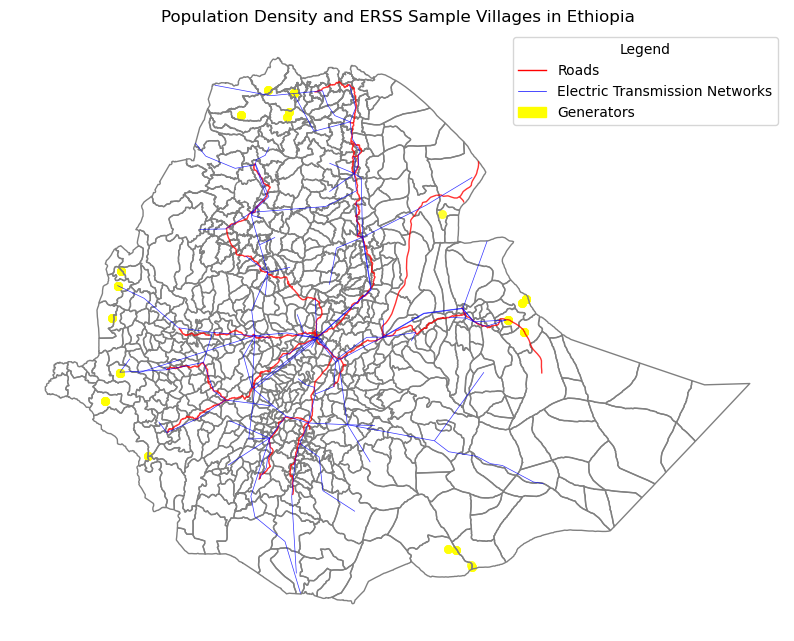

In [19]:
# Plot the shapefiles first before updating it with population density variable
fig, ax = plt.subplots(figsize=(10, 10))
ET_districts_gdf.boundary.plot(ax=ax, edgecolor="gray", linewidth=1)
ET_roads.plot(ax=ax, color="red", linewidth=1, label="Roads", alpha=0.8)
ET_elec_network.plot(ax=ax, color="blue", linewidth=0.5, label="Electric Trans. Networks", alpha=0.8)
ET_gen.plot(ax=ax, color="yellow", linewidth=0.5, label="Generators", alpha=0.8)

# Define legend entries
road_line = mlines.Line2D([0], [0], color="red", linewidth=1, label="Roads")
elec_line = mlines.Line2D([0], [0], color="blue", linewidth=0.5, label="Electric Transmission Networks")
gen_patch = mpatches.Patch(color="yellow", label="Generators")

# Additional plot settings
ax.legend(handles=[road_line, elec_line, gen_patch], loc="upper right", title="Legend")
plt.title("Population Density and ERSS Sample Villages in Ethiopia")
plt.axis("off")
plt.show()

In [20]:
# Load and process ERSS village data
ET_erss_villages = pd.read_csv(os.path.join(ET_data_path, "pub_eth_householdgeovariables_y1.csv"))
ET_erss_villages

,household_id,ea_id,qa_type,dist_road,dist_popcenter,dist_market,dist_borderpost,dist_admctr,af_bio_1,af_bio_8,...,eviarea_avg,evimax_avg,grn_avg,sen_avg,h2011_eviarea,h2011_evimax,h2011_grn,h2011_sen,LAT_DD_MOD,LON_DD_MOD
0,1010101601002,1010101601,1,50.3,53.2,105.3,133.9,198.4,264,258,...,47,0.4357,178,257,41,0.3747,185,264,14.353816,37.890876
1,1010101601017,1010101601,1,50.0,52.9,105.6,134.6,198.0,263,257,...,47,0.4357,178,257,41,0.3747,185,264,14.353816,37.890876
2,1010101601034,1010101601,1,46.0,49.2,100.1,135.1,194.6,262,256,...,47,0.4357,178,257,41,0.3747,185,264,14.353816,37.890876
3,1010101601049,1010101601,1,46.0,49.2,100.1,135.1,194.6,262,256,...,47,0.4357,178,257,41,0.3747,185,264,14.353816,37.890876
4,1010101601064,1010101601,1,46.1,49.3,100.1,135.0,194.8,262,256,...,47,0.4357,178,257,41,0.3747,185,264,14.353816,37.890876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,15010203102067,15010203102,1,19.6,53.3,54.8,110.9,56.3,238,257,...,25,0.2307,216,264,22,0.2100,201,263,9.746772,42.308967
3913,15010203102087,15010203102,1,19.3,53.1,54.6,111.3,55.9,238,257,...,25,0.2307,216,264,22,0.2100,201,263,9.746772,42.308967
3914,15010203102099,15010203102,1,19.4,53.0,54.5,111.2,55.9,238,257,...,25,0.2307,216,264,22,0.2100,201,263,9.746772,42.308967
3915,15010203102109,15010203102,1,19.4,53.0,54.5,111.3,55.9,238,257,...,25,0.2307,216,264,22,0.2100,201,263,9.746772,42.308967


In [21]:
# Group by enumeration area to avoid overlapping points
ET_erss_villages = pd.read_csv(os.path.join(ET_data_path, "pub_eth_householdgeovariables_y1.csv"))
ET_erss_villages = ET_erss_villages.groupby("ea_id").agg({
    "LAT_DD_MOD": "mean",
    "LON_DD_MOD": "mean"
}).reset_index()

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(ET_erss_villages["LON_DD_MOD"], ET_erss_villages["LAT_DD_MOD"])]
ET_erss_villages_geo = gpd.GeoDataFrame(ET_erss_villages, geometry=geometry, crs="EPSG:4326")

# Reproject to match the districts' CRS
ET_erss_villages_geo = ET_erss_villages_geo.to_crs(ET_districts_gdf.crs)

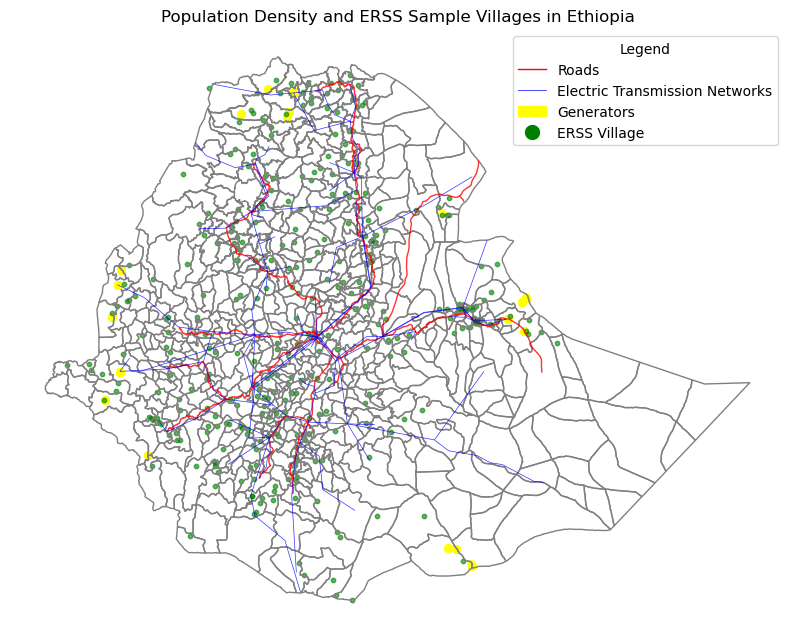

In [22]:
# Plot infrastructure with ERSS Villages
fig, ax = plt.subplots(figsize=(10, 10))
ET_districts_gdf.boundary.plot(ax=ax, edgecolor="gray", linewidth=1)
ET_roads.plot(ax=ax, color="red", linewidth=1, label="Roads", alpha=0.8)
ET_elec_network.plot(ax=ax, color="blue", linewidth=0.5, label="Electric Trans. Networks", alpha=0.8)
ET_gen.plot(ax=ax, color="yellow", linewidth=0.5, label="Generators", alpha=0.8)
ET_erss_villages_geo.plot(ax=ax, color="green", marker='o', markersize=10, alpha=0.6, label="ERSS Village")

# Define legend entries
road_line = mlines.Line2D([0], [0], color="red", linewidth=1, label="Roads")
elec_line = mlines.Line2D([0], [0], color="blue", linewidth=0.5, label="Electric Transmission Networks")
gen_patch = mpatches.Patch(color="yellow", label="Generators")
villages_marker = mlines.Line2D([0], [0], color="green", marker='o', markersize=10, linestyle='None', label="ERSS Village")

# Additional plot settings
ax.legend(handles=[road_line, elec_line, gen_patch, villages_marker], loc="upper right", title="Legend")
plt.title("Population Density and ERSS Sample Villages in Ethiopia")
plt.axis("off")
plt.show()

In [23]:
# Load raster data (ensure file is not .crdownload) to factor in population density
ET_popden = rasterio.open(os.path.join(ET_data_path, "eth_ppp_2020.tif.crdownload"))

# Match CRS of districts to raster
ET_districts_gdf = ET_districts_gdf.to_crs(ET_popden.crs)

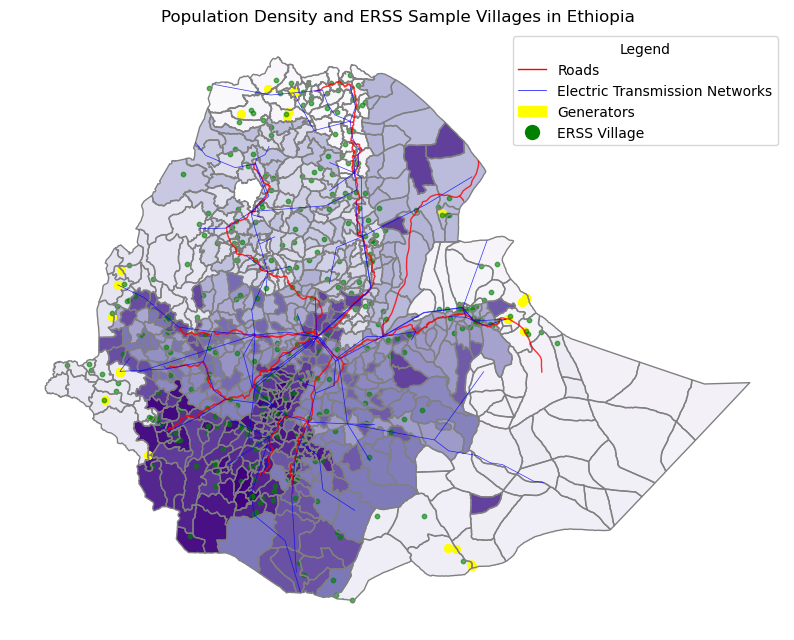

In [24]:
# Plot all layers together with population density
fig, ax = plt.subplots(figsize=(10, 10))

ET_districts_gdf.boundary.plot(ax=ax, edgecolor="gray", linewidth=1)
ET_districts_gdf.plot(ax=ax, legend=True, cmap="Purples", 
                      legend_kwds={"label": "Population Density (people/km²)", "orientation": "horizontal"})
ET_roads.plot(ax=ax, color="red", linewidth=1, label="Roads", alpha=0.8)
ET_elec_network.plot(ax=ax, color="blue", linewidth=0.5, label="Electric Trans. Networks", alpha=0.8)
ET_gen.plot(ax=ax, color="yellow", linewidth=0.5, label="Generators", alpha=0.8)
ET_erss_villages_geo.plot(ax=ax, color="green", marker='o', markersize=10, alpha=0.6, label="ERSS Village")

# Define legend entries
road_line = mlines.Line2D([0], [0], color="red", linewidth=1, label="Roads")
elec_line = mlines.Line2D([0], [0], color="blue", linewidth=0.5, label="Electric Transmission Networks")
gen_patch = mpatches.Patch(color="yellow", label="Generators")
villages_marker = mlines.Line2D([0], [0], color="green", marker='o', markersize=10, linestyle='None', label="ERSS Village")

# Additional plot settings
ax.legend(handles=[road_line, elec_line, gen_patch, villages_marker], loc="upper right", title="Legend")
plt.title("Population Density and ERSS Sample Villages in Ethiopia")
plt.axis("off")
plt.show()

In [20]:
# Vietnam: Replicating Roadmap of Vietnam
# Objective: visualize the evolution of Vietnam's road network using more recent (2025) data, in comparison to earlier maps (e.g., 2010), highlighting infrastructure expansion
# Dataset: Vietnam Administrative boundaries shapefile from https://gadm.org/download_country.html and Vietnam roads shapefile (2025 data) from https://download.geofabrik.de/asia/vietnam.html

# Define the data path variable for Vietnam
VN_data_path = "C://Users//User//Raiza//Econ 138//Problem Set 2//3 Vietnam"

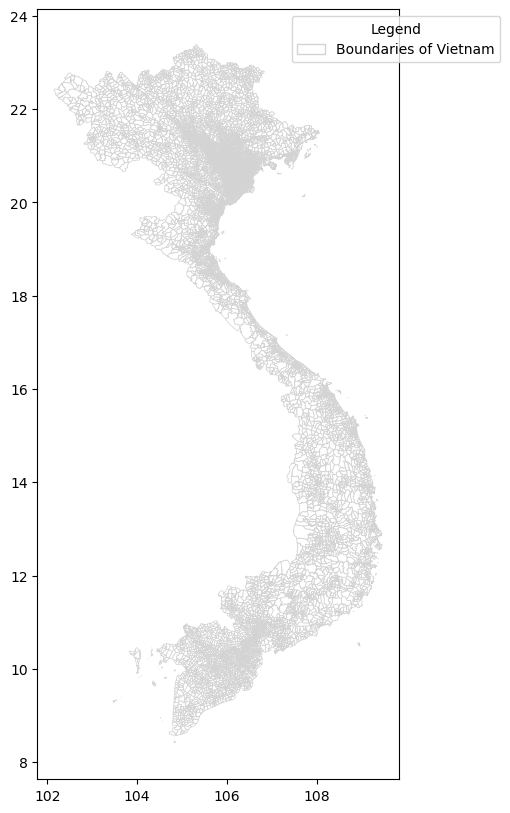

In [22]:
# Load Vietnam boundaries shapefile
VN_boundaries = gpd.read_file(os.path.join(VN_data_path, "gadm41_VNM_3.shp"))

# Plot Vietnam boundaries
fig, ax = plt.subplots(figsize=(12, 10))
VN_boundaries.plot(ax=ax, linewidth=0.5, facecolor="white", edgecolor="lightgray")

# Define legend entry
boundary_patch = mpatches.Patch(facecolor="white", edgecolor="lightgray", label="Boundaries of Vietnam")

# Additional plot settings
ax.legend(handles=[boundary_patch], loc="upper right", bbox_to_anchor=(1.3, 1), title="Legend")
plt.show()

In [23]:
# Load and inspect Vietnam road data
VN_roads = gpd.read_file(os.path.join(VN_data_path, "gis_osm_roads_free_1.shp"))

# Display unique road types
print(VN_roads['fclass'].unique())

['footway' 'residential' 'primary' 'tertiary' 'primary_link' 'secondary'
 'trunk' 'service' 'motorway' 'motorway_link' 'unclassified'
 'secondary_link' 'path' 'pedestrian' 'tertiary_link' 'track' 'steps'
 'trunk_link' 'cycleway' 'living_street' 'track_grade1' 'track_grade5'
 'track_grade4' 'track_grade3' 'unknown' 'track_grade2' 'busway'
 'bridleway']


In [24]:
# Define road classifications for plotting by starting with classifying roads by their functional type and assign color and linewidth for visualization
road_types = {
    'Freeway': {
        'fclasses': ['motorway', 'motorway_link'],
        'color': 'green',
        'linewidth': 1.5
    },
    
    'Dual Carriageway': {
        'fclasses': ['trunk', 'trunk_link'],
        'color': 'blue',
        'linewidth': 1.1
    },
    
    'Major Roads': {
        'fclasses': ['secondary'],
        'color': 'red',
        'linewidth': 0.5
    },
    
    'Minor Roads': {
        'fclasses': ['secondary_link', 'tertiary', 'tertiary_link', 'residential', 
                     'primary', 'primary_link', 'living_street'],
        'color': 'pink',
        'linewidth': 0.5
    }
}

In [25]:
# Identify "Other Roads" not included in the above categories
all_fclasses = set(VN_roads['fclass'].unique())
categorized_fclasses = set(fclass for v in road_types.values() for fclass in v['fclasses'])
other_fclasses = all_fclasses - categorized_fclasses

road_types['Other Roads'] = {
    'fclasses': list(other_fclasses),
    'color': 'yellow',
    'linewidth': 0.1
}

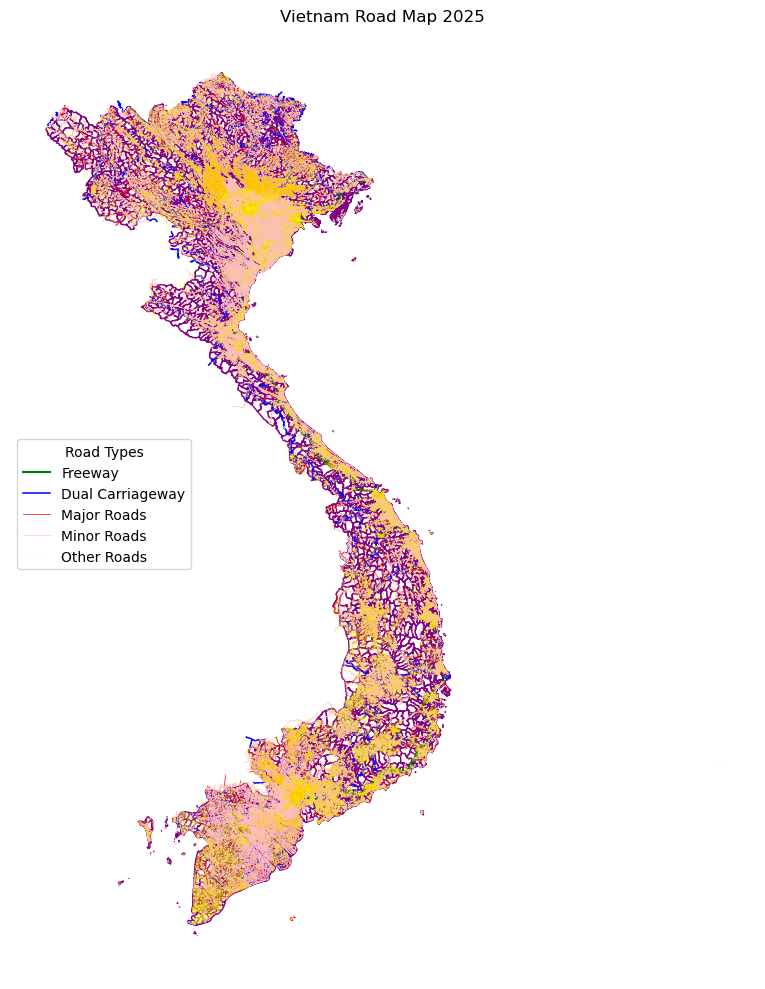

In [26]:
# Plot the 2025 Vietnam road map with classified road types
fig, ax = plt.subplots(figsize=(12, 10))

# Plot road layers based on road types
for label, props in road_types.items():
    fclasses = props["fclasses"]
    color = props["color"]
    lw = props["linewidth"]
    subset = VN_roads[VN_roads["fclass"].isin(fclasses)]
    
    if not subset.empty:
        subset.plot(ax=ax, linewidth=lw, color=color)

# Overlay with Vietnam boundary
VN_boundaries.plot(ax=ax, linewidth=1, facecolor="white", edgecolor="purple")

# Define legend entries
legend_patches = [mlines.Line2D([0], [0], color=props["color"], linewidth=props["linewidth"], label=label) 
                  for label, props in road_types.items()]

# Additional plot settings
ax.legend(handles=legend_patches, title="Road Types", loc="center left")
ax.set_title("Vietnam Road Map 2025")
ax.axis("off")
plt.tight_layout()
plt.show()

In [31]:
# Brazil: Replicating Road Infrastructure and Capital Cities
# Objective: Visualize Brazil's state boundaries, highway infrastructure, minimum spanning tree (MST), and capital cities. 
# Dataset: All shapefiles and data used are from the replication files available at: https://www.aeaweb.org/articles?id=10.1257/app.20180487

# Define the data path variable for Vietnam
BR_data_path = "C://Users//User//Raiza//Econ 138//Problem Set 2//4 Brazil"

In [32]:
# Read and simplify shapefiles
def read_and_simplify(path, tolerance=0.01):
    """
    Reads a shapefile from the specified path and simplifies its geometries.
    
    Parameters:
    - path (str): Path to the shapefile.
    - tolerance (float): Simplification tolerance. Higher means more simplification.
    
    Returns:
    - GeoDataFrame: Simplified geometries with topology preserved.
    """
    
    gdf = gpd.read_file(path)
    return gdf.simplify(tolerance, preserve_topology=True)

In [33]:
# Load shapefiles on state boundaries (from 1940s, simplified)
BR_states = read_and_simplify(os.path.join(BR_data_path, "uf1940_prj.shp"))
BR_states

0     POLYGON ((-71.07772 -9.82774, -71.16301 -9.875...
1     POLYGON ((-60.20051 5.26434, -60.19523 5.23823...
2     MULTIPOLYGON (((-46.43676 -1.01845, -46.43723 ...
3     MULTIPOLYGON (((-44.98657 -1.26615, -44.88522 ...
4     POLYGON ((-42.91993 -6.67101, -42.87215 -6.513...
5     POLYGON ((-41.18292 -4.01797, -41.25673 -4.034...
6     MULTIPOLYGON (((-37.04483 -4.81636, -37.04501 ...
7     MULTIPOLYGON (((-34.79543 -7.349, -34.79614 -7...
8     MULTIPOLYGON (((-32.39406 -3.82323, -32.3932 -...
9     MULTIPOLYGON (((-35.75809 -9.69271, -35.75839 ...
10    MULTIPOLYGON (((-36.91701 -10.84197, -36.91854...
11    MULTIPOLYGON (((-38.69611 -17.97886, -38.69629...
12    POLYGON ((-50.74653 -19.23991, -50.73415 -19.1...
13    MULTIPOLYGON (((-40.75322 -20.9243, -40.75601 ...
14    MULTIPOLYGON (((-41.82891 -22.78403, -41.82976...
15    MULTIPOLYGON (((-48.0355 -25.35703, -48.03773 ...
16    MULTIPOLYGON (((-48.40735 -25.84199, -48.4092 ...
17    MULTIPOLYGON (((-48.60042 -28.35188, -48.6

In [34]:
# Load shapefiles on highways (from 2000)
BR_highways = gpd.read_file(os.path.join(BR_data_path, "highways_2010_prj.shp"))
BR_highways

,OBJECTID,id_trecho_,vl_br,sg_uf,nm_tipo_tr,sg_tipo_tr,desc_coinc,vl_codigo,ds_local_i,ds_local_f,...,versao_snv,id_versao,marcador,ICS,Shape_Leng,LABEL,dm_anlys,dm_anlys_p,dm_radial,geometry
0,44,151197.0,010,PA,Eixo Principal,B,-,010BPA0670,ENTR PA-251/322/456 (SÃO MIGUEL DO GUAMA),SANTA MARIA DO PARÁ,...,201609C,32.0,|,None,0.289649,BR-010,1,1,1,"LINESTRING (-47.47942 -1.62015, -47.47943 -1.6..."
1,45,151198.0,010,PA,Eixo Principal,B,-,010BPA0690,SANTA MARIA DO PARÁ,ENTR BR-316(A)/308(A),...,201609C,32.0,|,None,0.011767,None,1,1,1,"LINESTRING (-47.57685 -1.34906, -47.57685 -1.3..."
2,46,151199.0,010,PA,Eixo Principal,B,-,010BPA0710,ENTR BR-316(A)/308(A),ENTR PA-424 (P/COLÔNIA DO PRATA),...,201609C,32.0,|,None,0.066659,None,1,1,1,"LINESTRING (-47.5822 -1.33893, -47.58281 -1.33..."
3,47,151200.0,010,PA,Eixo Principal,B,-,010BPA0730,ENTR PA-424 (P/COLÔNIA DO PRATA),ENTR PA-127(A) (P/IGARAPÉ AÇU),...,201609C,32.0,|,None,0.087952,None,1,1,1,"LINESTRING (-47.64781 -1.32725, -47.64788 -1.3..."
4,48,151201.0,010,PA,Eixo Principal,B,-,010BPA0750,ENTR PA-127(A) (P/IGARAPÉ AÇU),ENTR PA-127(B) (BARRO BRANCO),...,201609C,32.0,|,None,0.053697,None,1,1,1,"LINESTRING (-47.73442 -1.31198, -47.73451 -1.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5647,6929,157662.0,494,RJ,Eixo Principal,B,-,494BRJ0330,ENTR BR-116/393(B),ENTR RJ-139 (GETULÂNDIA),...,201609C,32.0,|,None,0.128082,None,0,0,0,"LINESTRING (-44.12224 -22.56088, -44.12375 -22..."
5648,6942,157674.0,497,MG,Eixo Principal,B,-,497BMG0052,ENTR BR-364(B),ACESSO HONORÓPOLIS,...,201609C,32.0,|,None,0.486165,None,1,1,0,"LINESTRING (-49.55914 -19.5184, -49.55942 -19...."
5649,6943,157675.0,497,MG,Eixo Principal,B,-,497BMG0055,ACESSO HONORÓPOLIS,ENTR MG-255/426 (ITURAMA),...,201609C,32.0,|,None,0.263730,None,1,1,0,"LINESTRING (-50.01182 -19.56745, -50.0119 -19...."
5650,6948,157680.0,497,MG,Eixo Principal,B,-,497BMG0085,PORTO ALENCASTRO,DIV MG/MS (RIO PARANAÍBA),...,201609C,32.0,|,None,0.009434,None,1,1,0,"LINESTRING (-51.00978 -19.6618, -51.01249 -19...."


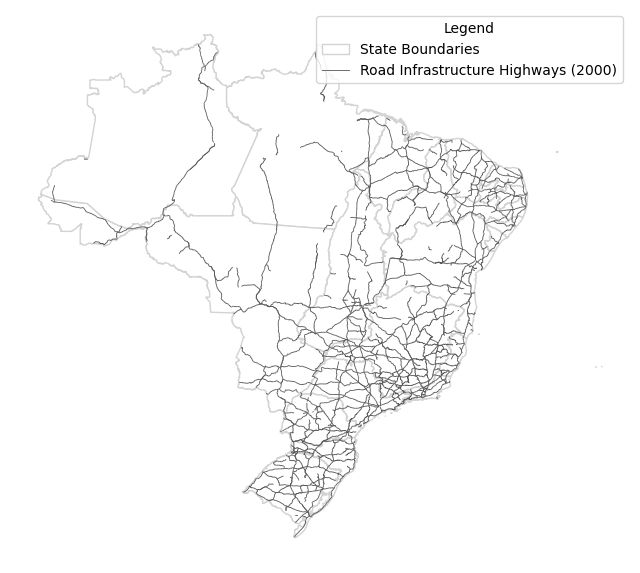

In [35]:
# Create a figure and an axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot state boundaries
BR_states.plot(ax=ax, facecolor="white", edgecolor="lightgray")

# Plot highways without using automatic labels
BR_highways.plot(ax=ax, linewidth=0.6, color="#565555")

# Define legend entries
highway_line = mlines.Line2D([0], [0], color="#565555", linewidth=0.6, label="Road Infrastructure Highways (2000)")
state_patch = mpatches.Patch(facecolor="white", edgecolor="lightgray", label="State Boundaries")

# Additional plot settings
ax.legend(handles=[state_patch, highway_line], loc="upper right", title="Legend")
ax.axis("off")
plt.show()

In [53]:
# Load and classify highways into two categories: radial and non-radial highways. 
# The column 'dm_anlys_p' == 1 indicates the highway is included in the analysis.
# The column 'dm_radial' indicates whether a highway is radial (1) or not (0).

# Filter highways included in the analysis
BR_non_radial_highways = BR_highways[
    (BR_highways["dm_anlys_p"] == 1) & (BR_highways["dm_radial"] == 0)
]
BR_radial_highways = BR_highways[
    (BR_highways["dm_anlys_p"] == 1) & (BR_highways["dm_radial"] == 1)
]

In [59]:
# Load and simplify the Minimum Spanning Tree (MST) for pie distribution
BR_mst_pie = gpd.read_file(os.path.join(BR_data_path, "mst_pie_prj.shp"))
BR_mst_pie

BR_mst_pie["geometry"] = BR_mst_pie["geometry"].simplify(tolerance=0.01, preserve_topology=True)
BR_mst_pie_simple = BR_mst_pie

In [63]:
# Load capital cities and extract coordinates
BR_capital_cities = gpd.read_file(os.path.join(BR_data_path, "brazil_capital_cities_prj.shp"))
BR_capital_cities

BR_capital_cities["X"] = BR_capital_cities.geometry.x
BR_capital_cities["Y"] = BR_capital_cities.geometry.y

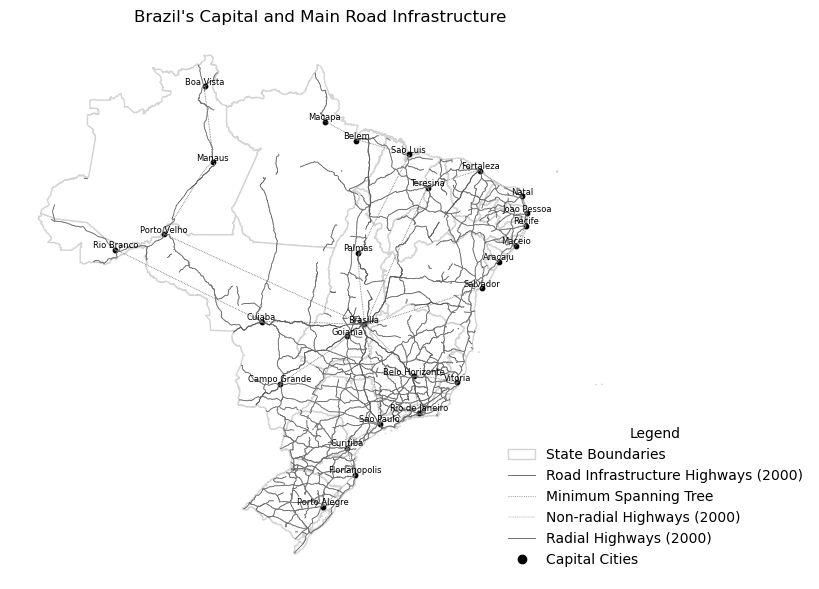

In [66]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot state boundaries
BR_states.plot(ax=ax, facecolor="white", edgecolor="lightgray")

# Plot highways and infrastructure layers
BR_highways.plot(ax=ax, linewidth=0.6, color="#565555")
BR_mst_pie_simple.plot(ax=ax, linewidth=0.6, linestyle=(0, (1, 1)), color="#777676")
BR_non_radial_highways.plot(ax=ax, linewidth=0.3, linestyle="--", color="#868686")
BR_radial_highways.plot(ax=ax, linewidth=0.6, linestyle="-", color="#565555")

# Plot capital cities as black dots
ax.scatter(BR_capital_cities["X"], BR_capital_cities["Y"], s=10, color="black")

# Label capital cities with their names
for idx, row in BR_capital_cities.iterrows():
    ax.text(row["X"], row["Y"], row["CITY_NAME"], fontsize=6, ha="center", va="bottom")

# Define legend entries
state_patch = mpatches.Patch(facecolor="white", edgecolor="lightgray", label="State Boundaries")
highway_line = mlines.Line2D([0], [0], color="#565555", linewidth=0.6, label="Road Infrastructure Highways (2000)")
mst_line = mlines.Line2D([0], [0], color="#777676", linewidth=0.6, linestyle="dotted", label="Minimum Spanning Tree")
non_radial_line = mlines.Line2D([0], [0], color="#868686", linewidth=0.3, linestyle="dashed", label="Non-radial Highways (2000)")
radial_line = mlines.Line2D([0], [0], color="#565555", linewidth=0.6, linestyle="-", label="Radial Highways (2000)")
city_marker = mlines.Line2D([0], [0], color="black", marker="o", markersize=6, linestyle="None", label="Capital Cities")

# Additional plot settings
ax.legend(handles=[state_patch, highway_line, mst_line, non_radial_line, radial_line, city_marker], 
          loc="lower right", bbox_to_anchor=(1.3, 0), title="Legend", frameon=False)
ax.set_title("Brazil's Capital and Main Road Infrastructure")
ax.axis("off")
plt.show()